# Sentiment Analysis: Using Recurrent Neural Networks

We can apply pretrained word vectors
to sentiment analysis.
Since the IMDb review dataset
is not very big,
using text representations
that were pretrained
on large-scale corpora
may reduce overfitting of the model.
As a specific example
illustrated in `fig_nlp-map-sa-rnn`,
we will represent each token
using the pretrained GloVe model,
and feed these token representations
into a multilayer bidirectional RNN
to obtain the text sequence representation,
which will
be transformed into 
sentiment analysis outputs (`Maas.Daly.Pham.ea.2011`).
For the same downstream application,
we will consider a different architectural
choice later.

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-sa-rnn.svg?raw=1)

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)
print('train_iter:', type(train_iter), len(train_iter))
print('test_iter:', type(test_iter), len(test_iter))

train_iter: <class 'torch.utils.data.dataloader.DataLoader'> 391
test_iter: <class 'torch.utils.data.dataloader.DataLoader'> 391


In [17]:
vocab.token_freqs

[('the', 287032),
 ('a', 155096),
 ('and', 152664),
 ('of', 142972),
 ('to', 132568),
 ('is', 103229),
 ('in', 85580),
 ('I', 65973),
 ('that', 64560),
 ('this', 57199),
 ('it', 54439),
 ('/><br', 50935),
 ('was', 46698),
 ('as', 42510),
 ('with', 41721),
 ('for', 41070),
 ('but', 33790),
 ('The', 33762),
 ('on', 30767),
 ('movie', 30506),
 ('are', 28499),
 ('his', 27687),
 ('film', 27402),
 ('have', 27126),
 ('not', 26266),
 ('be', 25512),
 ('you', 25123),
 ('he', 21676),
 ('by', 21426),
 ('at', 21295),
 ('one', 20692),
 ('an', 20626),
 ('from', 19239),
 ('who', 18838),
 ('like', 18133),
 ('all', 18048),
 ('they', 17840),
 ('has', 16472),
 ('so', 16336),
 ('just', 16326),
 ('about', 16286),
 ('or', 16224),
 ('her', 15830),
 ('out', 14368),
 ('some', 14207),
 ('very', 13082),
 ('more', 12950),
 ('This', 12279),
 ('would', 11923),
 ('what', 11685),
 ('when', 11488),
 ('good', 11436),
 ('only', 11106),
 ('their', 11008),
 ('It', 10952),
 ('if', 10899),
 ('had', 10876),
 ('really', 10815)

## Representing Single Text with RNNs

In text classifications tasks,
such as sentiment analysis,
a varying-length text sequence 
will be transformed into fixed-length categories.
In the following `BiRNN` class,
while each token of a text sequence
gets its individual
pretrained GloVe
representation via the embedding layer
(`self.embedding`),
the entire sequence
is encoded by a bidirectional RNN (`self.encoder`).
More concretely,
the hidden states (at the last layer)
of the bidirectional LSTM
at both the initial and final time steps
are concatenated 
as the representation of the text sequence.
This single text representation
is then transformed into output categories
by a fully-connected layer (`self.decoder`)
with two outputs ("positive" and "negative").


In [6]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size,
                               num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

Let us construct a bidirectional RNN with two hidden layers to represent single text for sentiment analysis.


In [7]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

## Loading Pretrained Word Vectors

Below we load the pretrained 100-dimensional (needs to be consistent with `embed_size`) GloVe embeddings for tokens in the vocabulary.


In [9]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Print the shape of the vectors
for all the tokens in the vocabulary.


In [19]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

We use these pretrained
word vectors
to represent tokens in the reviews
and will not update
these vectors during training.


In [20]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## Training and Evaluating the Model

Now we can train the bidirectional RNN for sentiment analysis.


loss 0.292, train acc 0.877, test acc 0.851
99.9 examples/sec on [device(type='cpu')]


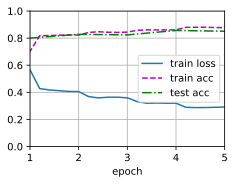

In [21]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

We define the following function to predict the sentiment of a text sequence using the trained model `net`.


In [22]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Finally, let us use the trained model to predict the sentiment for two simple sentences.


In [23]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [24]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [25]:
predict_sentiment(net, vocab, 'I don\'t like this movie')

'negative'

In [27]:
predict_sentiment(net, vocab, 'I am fan of this actor')

'positive'

In [34]:
# wrong
predict_sentiment(net, vocab, 'I am fan of this actor!')

'negative'

In [37]:
# wrong
predict_sentiment(net, vocab, 'I don\'t think this movie is good')

'positive'

## Summary

* Pretrained word vectors can represent individual tokens in a text sequence.
* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully-connected layer.